# Data Cleaning

For each IMU file, clean the IMU data, adjust the labels, and output these as CSV files.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from matplotlib.lines import Line2D
import joblib

from src.data.labels_util import load_labels, LabelCol, get_labels_file, load_clean_labels, get_workouts
from src.data.imu_util import (
    get_sensor_file, ImuCol, load_imu_data, Sensor, fix_epoch, resample_uniformly, time_to_row_range, get_data_chunk,
    normalize_with_bounds, data_to_features, list_imu_abspaths, clean_imu_data
)
from src.data.util import find_nearest, find_nearest_index, shift, low_pass_filter, add_col
from src.data.workout import Activity, Workout
from src.data.data import DataState
from src.data.clean_dataset import main as clean_dataset
from src.data.clean_labels import main as clean_labels
from src.visualization.visualize import multiplot

# import data types
from pandas import DataFrame
from numpy import ndarray
from typing import List, Tuple, Optional

## Clean IMU data

<IPython.core.display.Javascript object>


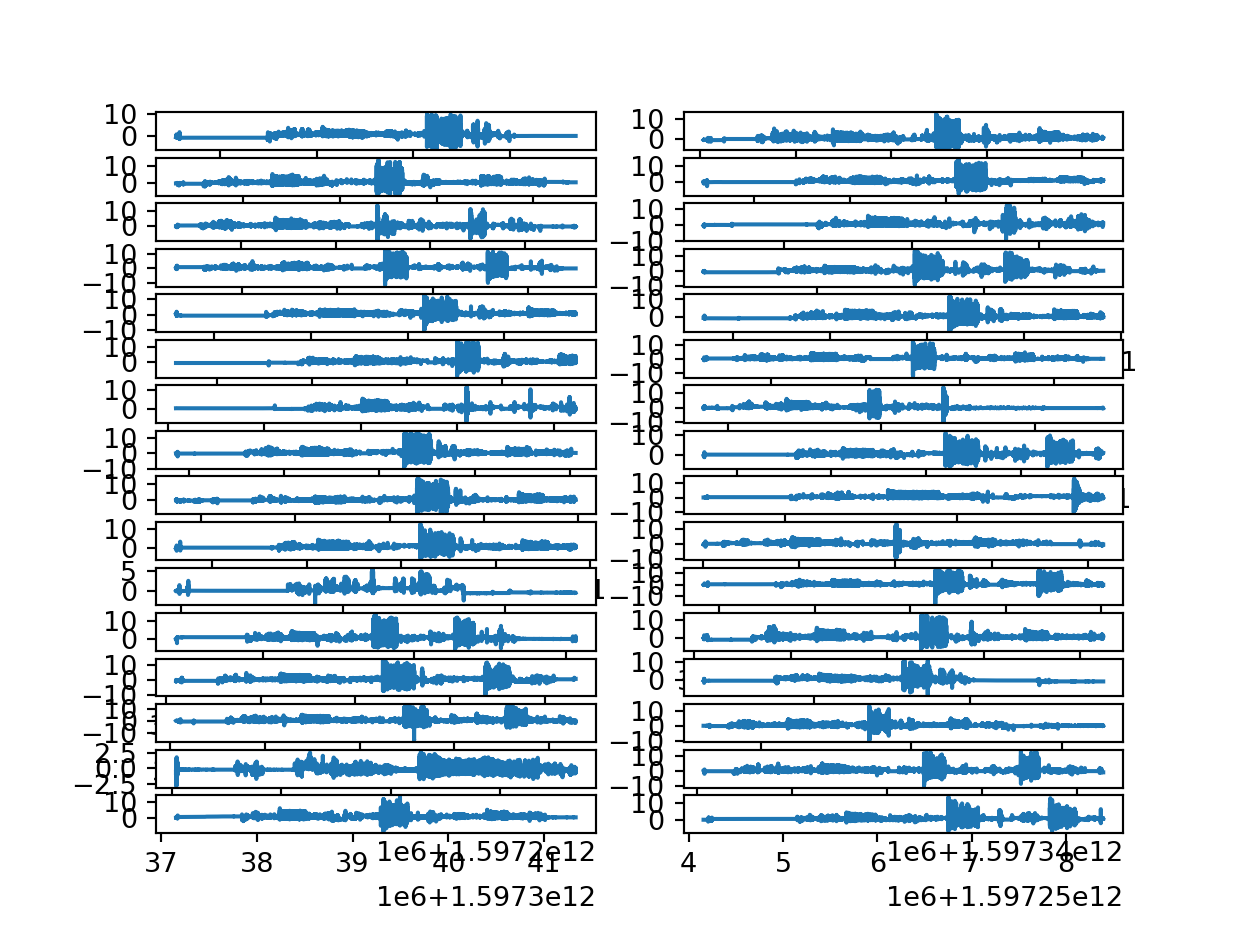

In [2]:
# Clean data (Uncomment when needed)
# clean_dataset()

# Test
cleaned_files = list_imu_abspaths(sensor_type=Sensor.Accelerometer, data_state=DataState.Clean)

def plot_helper(idx, plot):
    imu_data = np.load(cleaned_files[idx])
    plot.plot(imu_data[:, ImuCol.TIME], imu_data[:, ImuCol.XACCEL])
#     plot.plot(imu_data[:, ImuCol.TIME], imu_data[:, ImuCol.YACCEL])
#     plot.plot(imu_data[:, ImuCol.TIME], imu_data[:, ImuCol.ZACCEL])
    
multiplot(len(cleaned_files), plot_helper)

## Adjust Labels
A few raw IMU files seems to have corrupted timestamps, causing some labels to not properly map to their data point. We note these labels in the cleaned/adjusted labels. They'll be handled in the model fitting.

In [3]:
# Adjust labels (Uncomment when needed)
# clean_labels()

# Test
raw_boot_labels: ndarray = load_labels(get_labels_file(Activity.Boot, DataState.Raw), Activity.Boot)
raw_pole_labels: ndarray = load_labels(get_labels_file(Activity.Pole, DataState.Raw), Activity.Pole)
clean_boot_labels: ndarray = load_clean_labels(Activity.Boot)
clean_pole_labels: ndarray = load_clean_labels(Activity.Pole)

# print('Raw Boot')
# print(raw_boot_labels[:50,])
# print('Clean Boot')
# print(clean_boot_labels[:50,])
# print('Raw Pole')
# print(raw_pole_labels[:50,])
# print('Clean Pole')
# print(clean_pole_labels[:50,])

## Examine Data Integrity
Make sure that labels for steps are still reasonable after data cleaning.

**Something to consider**: one area of concern are the end steps labels for poles labels. Pole lift-off (end of step) occurs at a min-peak. Re-sampling, interpolation, and the adjustment of labels may cause the end labels to deviate slightly from the min-peak. (The graph seems okay, with some points slightly off the peak, but it's not too common.) We can make the reasonable assumption that data points are sampled approximately uniformly. This may affect the accuracy of using a low-pass filter and (for workout detection) FFT.

Number of workouts: 35
Sensor 14R


<IPython.core.display.Javascript object>


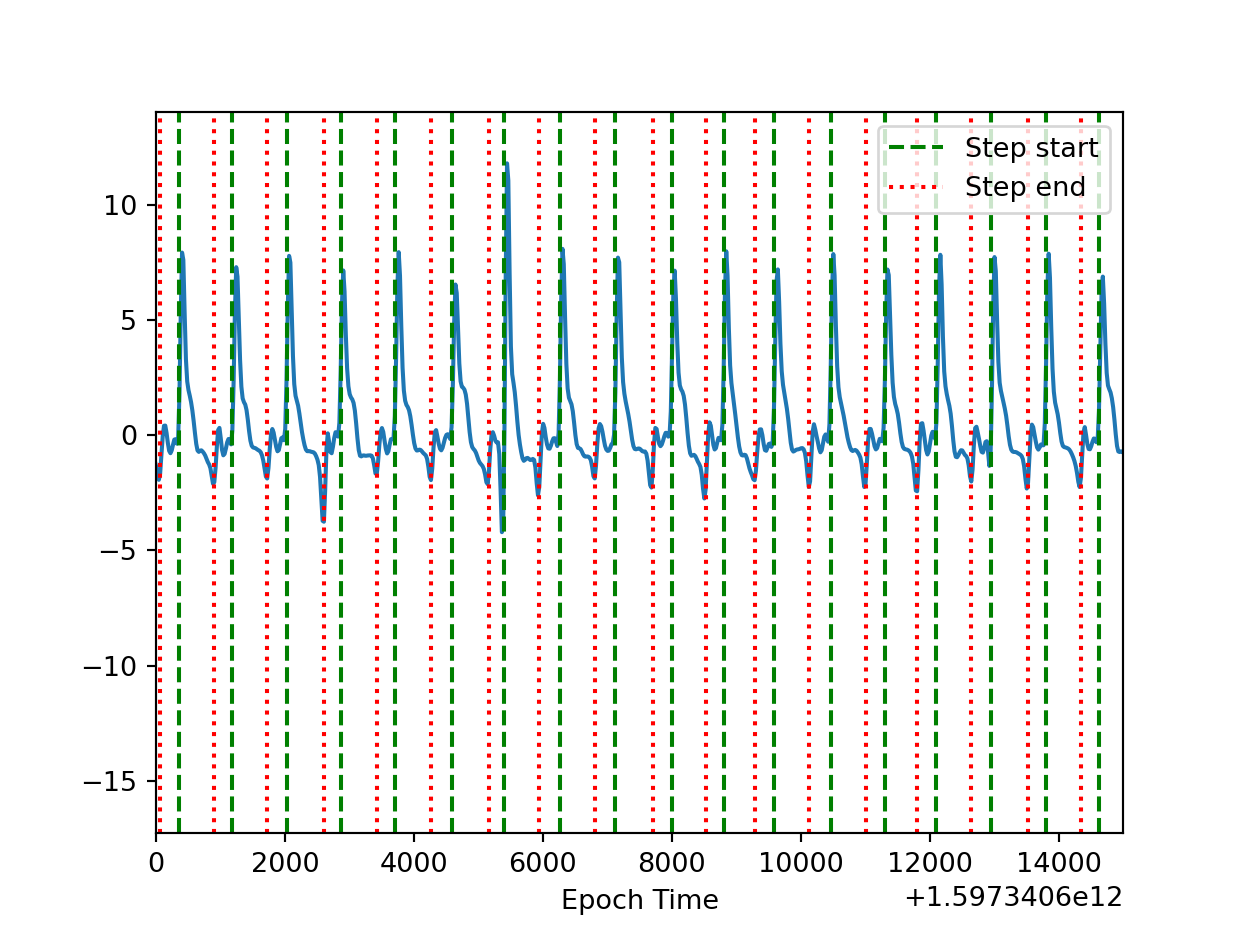

In [4]:
# CHOOSE a workout and test type (pole or boot) to examine
workout_idx = 5
selected_labels = clean_pole_labels

workouts: List[Workout] = get_workouts(selected_labels)
print('Number of workouts: %d' % len(workouts))

workout = workouts[workout_idx]
print('Sensor %s' % workout.sensor)

def plot_helper(idx, plot):
    # Plot IMU data
    imu_data: ndarray = np.load(
        get_sensor_file(sensor_name=workout.sensor, sensor_type=Sensor.Accelerometer, data_state=DataState.Clean))
    plot.plot(imu_data[:, ImuCol.TIME], imu_data[:, ImuCol.XACCEL])
#     plot.plot(imu_data[:, ImuCol.TIME], imu_data[:, ImuCol.YACCEL])
#     plot.plot(imu_data[:, ImuCol.TIME], imu_data[:, ImuCol.ZACCEL])
    plot.set_xlabel('Epoch Time')


    # Plot step labels
    for i in range(workout.labels.shape[0]):
        start_row, end_row = workout.labels[i, LabelCol.START], workout.labels[i, LabelCol.END]
        plot.axvline(x=imu_data[start_row, ImuCol.TIME], color='green', linestyle='dashed')
        plot.axvline(x=imu_data[end_row, ImuCol.TIME], color='red', linestyle='dotted')
    
    legend_items = [Line2D([], [], color='green', linestyle='dashed', label='Step start'), 
                    Line2D([], [], color='red', linestyle='dotted', label='Step end')]
    plot.legend(handles=legend_items)
    
    # Zoom (REMOVE to see the entire graph)
    plot.set_xlim([1597340600000, 1597340615000])
    
multiplot(1, plot_helper)

Let's compare the cleaned labels to the original labels.

In [5]:
# CHOOSE a workout and test type (pole or boot) to examine
workout_idx = 5
selected_labels = raw_pole_labels

workouts: List[Workout] = get_workouts(selected_labels)
print('Number of workouts: %d' % len(workouts))

workout = workouts[workout_idx]
print('Sensor %s' % workout.sensor)

def plot_helper(idx, plot):
    # Plot IMU data
    imu_data: ndarray = load_imu_data(
        get_sensor_file(sensor_name=workout.sensor, sensor_type=Sensor.Accelerometer, data_state=DataState.Raw))
    plot.plot(imu_data[:, ImuCol.XACCEL])
#     plot.plot(imu_data[:, ImuCol.TIME], imu_data[:, ImuCol.YACCEL])
#     plot.plot(imu_data[:, ImuCol.TIME], imu_data[:, ImuCol.ZACCEL])
    plot.set_xlabel('Row Index')

    # Plot step labels
    for i in range(workout.labels.shape[0]):
        # find labels rows
        start_epoch, end_epoch = workout.labels[i, LabelCol.START], workout.labels[i, LabelCol.END]
        start_row = np.where(imu_data[:, ImuCol.TIME].astype(int) == int(start_epoch))[0]
        end_row = np.where(imu_data[:, ImuCol.TIME].astype(int) == int(end_epoch))[0]
        if len(start_row) != 1 or len(end_row) != 1:
            print('Bad workout')
            return
        start_row, end_row = start_row[0], end_row[0]
        
        plot.axvline(x=start_row, color='green', linestyle='dashed')
        plot.axvline(x=end_row, color='red', linestyle='dotted')
    
    legend_items = [Line2D([], [], color='green', linestyle='dashed', label='Step start'), 
                    Line2D([], [], color='red', linestyle='dotted', label='Step end')]
    plot.legend(handles=legend_items)
    
    # Zoom (REMOVE to see the entire graph)
    plot.set_xlim([124500, 125000])
    
multiplot(1, plot_helper)

Number of workouts: 39
Sensor 14L


<IPython.core.display.Javascript object>

Make sure NaN labels were persisted during the label data's save/load process.

In [6]:
def count_errors(labels: ndarray):
    for workout in get_workouts(labels):
        boot: ndarray = workout.labels
        num_errors = np.count_nonzero(
            np.isnan(boot[:, LabelCol.START].astype(np.float64)) | np.isnan(boot[:, LabelCol.END].astype(np.float64)))
        if num_errors != 0:
            print('Number of labels that could not be mapped for sensor %s: %d' % (workout.sensor, num_errors))

clean_boot_labels: ndarray = load_clean_labels(Activity.Boot)
clean_pole_labels: ndarray = load_clean_labels(Activity.Pole)
print('Boot labels')
count_errors(clean_boot_labels)
print('Pole labels')
count_errors(clean_pole_labels)

Boot labels
Number of labels that could not be mapped for sensor 12L: 5
Number of labels that could not be mapped for sensor 17R: 19
Pole labels
Number of labels that could not be mapped for sensor 12L: 9
Number of labels that could not be mapped for sensor 12L: 17
Number of labels that could not be mapped for sensor 17R: 26
Number of labels that could not be mapped for sensor 9R: 6
